In [ ]:
from utils.imports import *

In [ ]:
from utils.start_spark import spark
! start http://localhost:4040/jobs/

In [ ]:
%%capture 
from files.dfs import *
readAllCsvs(spark)

# Cleanup

In [ ]:
cleaned_up = train.df

Ao fazer uma pesquisa adicional sobre esta base de dados pudemos observar [várias inconsistências nela](https://www.kaggle.com/code/abaojiang/eda-on-game-progress), como número de checkpoints não adequados, saltos de `index`es fora de checkpoints, e *primary keys* duplciadas.

## `elapsed_time`

In [ ]:
elapsedTimes = train.df.groupby("session_id") \
    .agg(max(col("elapsed_time")).alias("max_elipsed_time")) \
    .withColumn("total_hours", round(col("max_elipsed_time")/3.6e6, 5)) \
    .toPandas()

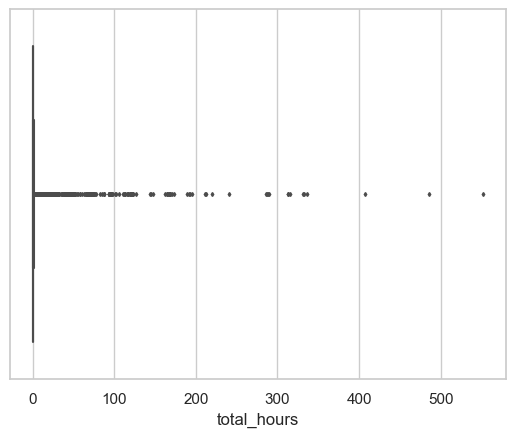

In [ ]:
sns.set_theme(style="whitegrid")
temp = sns.boxplot(x = elapsedTimes["total_hours"], fliersize = 2)

<Axes: xlabel='total_hours', ylabel='Count'>

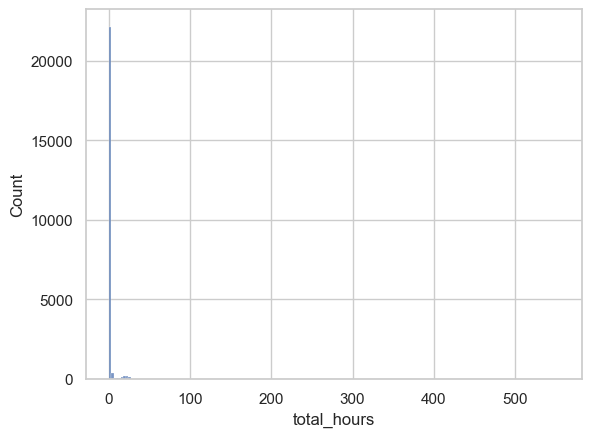

In [ ]:
sns.histplot(x = elapsedTimes["total_hours"], binwidth = 3)

<Axes: xlabel='total_hours', ylabel='Count'>

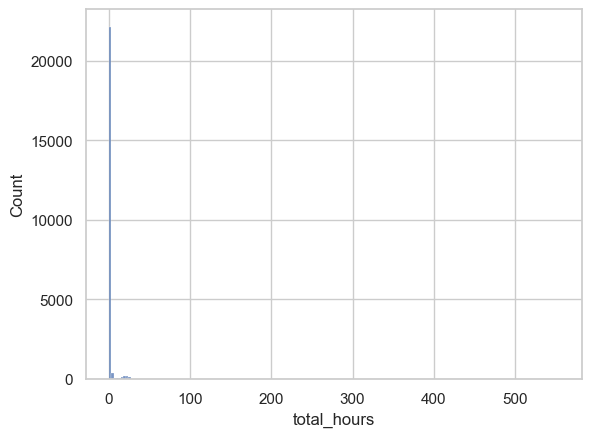

In [ ]:
sns.histplot(x = elapsedTimes["total_hours"], binwidth = 3)

## `checkpoint`

In [ ]:
sessions_to_rem = train.df.filter(col("event_name") == "checkpoint") \
    .groupBy("session_id") \
    .count() \
    .filter(col("count") != 3)
    # .filter(col("session_id") == 21020618143279870)# mais á frente

In [ ]:
cleaned_up = cleaned_up.filter(~col("session_id").isin([i.session_id for i in sessions_to_rem.collect()]))

In [ ]:
if False:
    cleaned_up.write.mode("overwrite").parquet(r".\data\df_cleaned_up")

# Transformação

In [ ]:
splited = train_labels.df \
    .select(
        split("session_id", "_").alias("both"),
        "correct"
    ).select(
        col("both")[0].alias("session_id"),
        col("both")[1].alias("question"),
        col("correct").alias("isCorrect")
    ).cache()
splited.groupby("session_id").count().sort(col("count").asc()).limit(3)

session_id,count
20100209442654932,18
20100216323445964,18
20100308255503228,18


In [ ]:
(pivoted := splited.groupby("session_id").pivot("question").agg(first("isCorrect"))).cache()
pivoted.limit(5)

session_id,q1,q10,q11,q12,q13,q14,q15,q16,q17,q18,q2,q3,q4,q5,q6,q7,q8,q9
20110512573169570,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
20100216323445964,0,0,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,1
21020308080777748,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,0,1,0
21040512382351228,1,0,1,1,0,1,0,0,1,1,0,1,0,0,1,1,0,0
22030108542877704,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,1,1,0


ModuleNotFoundError: No module named 'cairosvg'

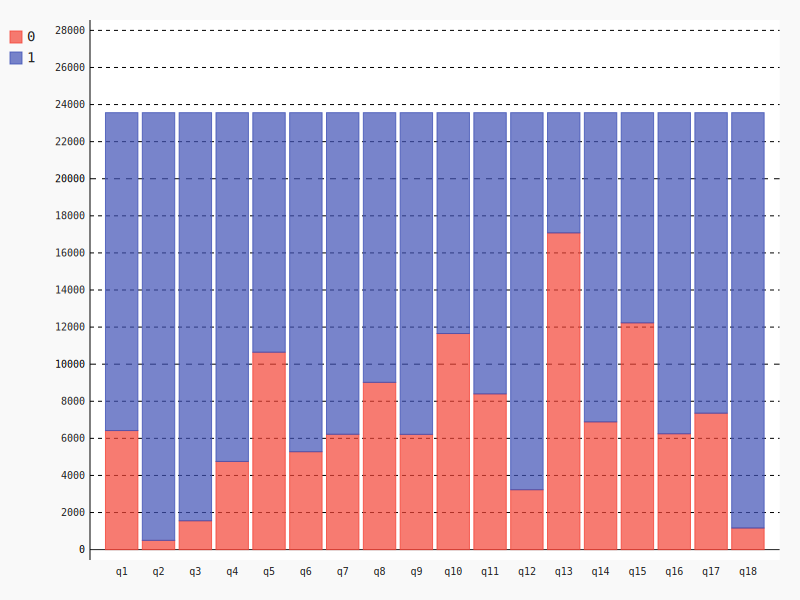

In [ ]:
bar_chart = pygal.StackedBar()
bar_chart.title = ''
bar_chart.x_labels = map(str, [f"q{z}" for z in range(1,19)])
bar_chart.range = [0, 28000]
bar_chart.add('0', [pivoted.select(k).filter(f"{k}==0").count() for k in [f"q{z}" for z in range(1,19)]])
bar_chart.add('1',  [pivoted.select(k).filter(f"{k}==1").count() for k in [f"q{z}" for z in range(1,19)]])
bar_chart

In [ ]:
sessions_to_get = cleaned_up.select("session_id").distinct().sample(fraction=0.01, seed=1).cache()

In [ ]:
amostra = train.df.join(
    sessions_to_get, 
    train.df.session_id == sessions_to_get["session_id"],
    "leftsemi"
).cache()
amostra.limit(5)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20100015580955656,0,0,cutscene_click,basic,0,null,-294.9914052226322,21.68531382977218,null,null,null,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,1,0,1,0-4
20100015580955656,1,6290,person_click,basic,0,null,-414.99140522263224,86.6853138297722,null,null,null,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,1,0,1,0-4
20100015580955656,2,12132,person_click,basic,0,null,-393.99140522263224,-149.31468617022782,null,null,null,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,1,0,1,0-4
20100015580955656,3,14820,person_click,basic,0,null,-393.99140522263224,-149.31468617022782,null,null,null,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,1,0,1,0-4
20100015580955656,4,16945,person_click,basic,0,null,-382.99140522263224,-150.31468617022782,null,null,null,Meetings are BORING!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,1,0,1,0-4


In [ ]:
if 'stages' in sys.modules: del sys.modules['stages']
from stages import *

pipeline_no_ML = Pipeline(stages = [
    the_transformer(
        add_id,
        (elapsed_to_diff, "elapsed_time", "elapsed_diff_ms"),
        (negative_to_0, "elapsed_diff_ms"),
        (elapsed_to_hours, "elapsed_time", "elapsed_time_h"),
        agg1,
        agg2,
        typeOfText,
    ),
    VectorAssembler(inputCols = ["inv_total_time_h", "inv_total_time_h_0-4", "inv_total_time_h_5-12"], outputCol = "inv_time_to_stand"),
    StandardScaler(inputCol = "inv_time_to_stand", outputCol = "inv_time_standed", withMean = True),
    StringIndexer(inputCol = "type_of_script", outputCol = "index_of_type_of_script"),
    OneHotEncoder(inputCol = "index_of_type_of_script", outputCol="dummies_of_type_of_script"), #sparse vector
])
pipeline_fitted = pipeline_no_ML.fit(amostra)

In [ ]:
(transformed := pipeline_fitted.transform(amostra)).cache()
transformed.limit(1)

session_id,max_index,inv_total_time_h_0-4,inv_total_time_h_5-12,inv_total_time_h,obs_opcional,obs_no_in,notebook_opens,notebook_explorer,fullscreen,hq,music,avg_elapsed_diff_ms_cutscene,avg_elapsed_diff_ms_person,avg_elapsed_diff_ms_navigate,type_of_script,inv_time_to_stand,inv_time_standed,index_of_type_of_script,dummies_of_type_of_script
20100015580955656,856,9.361396720390683,2.6608069784097683,1.2766306030341963,5,1,12,0,1,0,1,2504.8656427286564,2613.4383233965673,4937.380227314577,normal,"[1.2766306030341963,9.361396720390683,2.6608069...","[-0.5985181548513421,-0.7861843022701064,-0.987...",0.0,"(3,[0],[1.0])"


In [ ]:
trans_joined = transformed.join(pivoted, transformed.session_id == pivoted.session_id, "left")
trans_joined.limit(1)

session_id,max_index,inv_total_time_h_0-4,inv_total_time_h_5-12,inv_total_time_h,obs_opcional,obs_no_in,notebook_opens,notebook_explorer,fullscreen,hq,music,avg_elapsed_diff_ms_cutscene,avg_elapsed_diff_ms_person,avg_elapsed_diff_ms_navigate,type_of_script,inv_time_to_stand,inv_time_standed,index_of_type_of_script,dummies_of_type_of_script,session_id,q1,q10,q11,q12,q13,q14,q15,q16,q17,q18,q2,q3,q4,q5,q6,q7,q8,q9
20100015580955656,856,9.361396720390683,2.6608069784097683,1.2766306030341963,5,1,12,0,1,0,1,2504.8656427286564,2613.4383233965673,4937.380227314577,normal,"[1.2766306030341963,9.361396720390683,2.6608069...","[-0.5985181548513421,-0.7861843022701064,-0.987...",0.0,"(3,[0],[1.0])",20100015580955656,1,1,1,1,0,1,0,0,0,1,1,1,1,1,1,1,0,1


In [ ]:
if False:
    sessions_to_get = cleaned_up.select("session_id").distinct().sample(fraction=0.80, seed=1)
    train_to_parquet = train.df.join(
        sessions_to_get, 
        train.df.session_id == sessions_to_get["session_id"],
        "leftsemi"
    )
    test_to_parquet = train.df.join(
        sessions_to_get, 
        train.df.session_id == sessions_to_get["session_id"],
        "leftanti"
    )
    trans_all = pipeline_fitted.transform(train.df)

In [ ]:
if True:
    trans_all = spark.read.parquet(r".\data\trans_all")

In [ ]:
all_pandas = trans_all.toPandas()

In [ ]:
all_pandas["totalT"] = all_pandas["inv_time_standed"].apply(lambda x: x[0])

In [ ]:
all_pandas.sort_values(by = "totalT", ascending=False)

,session_id,max_index,inv_total_time_h_0-4,inv_total_time_h_5-12,inv_total_time_h,obs_opcional,obs_no_in,notebook_opens,notebook_explorer,fullscreen,...,music,avg_elapsed_diff_ms_cutscene,avg_elapsed_diff_ms_person,avg_elapsed_diff_ms_navigate,type_of_script,inv_time_to_stand,inv_time_standed,index_of_type_of_script,dummies_of_type_of_script,totalT
9122,21020618143279870,751,3636.363636,3625.377644,3603.603604,2,0,0,0,0,...,1,1.288235e+02,112.731240,1.597690e+02,dry,"[3603.6036036036035, 3636.363636363636, 3625.3...","[4097.120538193931, 591.1223857466057, 1877.03...",3.0,"(0.0, 0.0, 0.0)",4097.120538
21226,22040212485055840,1800,47.258359,17.068245,7.902171,2,0,8,0,0,...,1,2.393270e+02,156.705158,3.290831e+02,normal,"[7.902171121515636, 47.25835882221668, 17.0682...","[6.938166839231258, 5.398409796324838, 6.48101...",0.0,"(1.0, 0.0, 0.0)",6.938167
12562,21040419024984496,1035,46.049939,16.557891,7.438585,2,0,2,0,0,...,1,4.748607e+02,348.454435,4.572505e+02,nohumor,"[7.4385851810985555, 46.04993860008187, 16.557...","[6.410828550247422, 5.201201678313774, 6.21644...",1.0,"(0.0, 1.0, 0.0)",6.410829
16665,21090422004798964,1440,46.876221,16.162414,7.077962,2,0,0,0,0,...,1,3.013517e+02,284.726798,4.389941e+02,normal,"[7.077961782938573, 46.87622073491497, 16.1624...","[6.000612214561899, 5.33604677753657, 6.011427...",0.0,"(1.0, 0.0, 0.0)",6.000612
12872,21040521480327576,1094,44.668338,16.213952,7.074804,1,0,2,0,0,...,1,4.406349e+02,325.553992,4.645260e+02,normal,"[7.074804263748702, 44.66833759336924, 16.2139...","[5.997020473264651, 4.975731325049862, 6.03814...",0.0,"(1.0, 0.0, 0.0)",5.997020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17979,21110312203708684,1257,0.003245,0.003243,0.003010,2,2,21,0,0,...,1,1.391467e+03,1274.305115,8.496030e+06,noskark,"[0.0030096106196879557, 0.003244805778004017, ...","[-2.0472875337274763, -2.313387748006985, -2.3...",2.0,"(0.0, 0.0, 1.0)",-2.047288
23433,22090510463732496,2047,0.002970,0.002970,0.002970,6,7,10,6,0,...,1,1.430072e+04,1868.835334,7.639211e+05,dry,"[0.0029697638492788155, 0.0029702278934825885,...","[-2.047332860226615, -2.313432557740273, -2.36...",3.0,"(0.0, 0.0, 0.0)",-2.047333
15803,21080510571504504,991,5.285086,1.996834,0.002452,2,2,21,6,0,...,1,4.004027e+03,3925.167249,2.327779e+06,nohumor,"[0.0024517716978000115, 5.285086367119716, 1.9...","[-2.047922086669984, -1.4514177024340311, -1.3...",1.0,"(0.0, 1.0, 0.0)",-2.047922
18889,22000410231856948,1595,0.002061,0.002058,0.002058,5,2,42,3,0,...,1,8.942104e+06,2611.631553,2.197904e+03,normal,"[0.0020579738140496435, 0.0020605385304449833,...","[-2.048370039647237, -2.3135810144807127, -2.3...",0.0,"(1.0, 0.0, 0.0)",-2.048370


In [ ]:
train.df.filter("session_id == 21020618143279870")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
21020618143279870,0,655,cutscene_click,basic,0,null,-196.9914052226321,-162.31468617022782,null,null,null,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
21020618143279870,1,756,person_click,basic,0,null,-320.9914052226322,-23.31468617022785,null,null,null,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
21020618143279870,2,607,person_click,basic,0,null,-320.9914052226322,-20.314686170227798,null,null,null,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
21020618143279870,3,474,person_click,basic,0,null,-319.9914052226321,-17.314686170227812,null,null,null,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
21020618143279870,4,308,person_click,basic,0,null,-318.9914052226322,-14.31468617022783,null,null,null,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
21020618143279870,5,392,person_click,basic,0,null,-318.9914052226322,-14.31468617022783,null,null,null,"Sure thing, Jo. Grab your notebook and come ups...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
21020618143279870,6,810,person_click,basic,0,null,213.32710151559488,-206.52164599880712,null,null,null,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
21020618143279870,7,528,person_click,basic,0,null,225.58620000603523,-207.41755627145926,null,null,null,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
21020618143279870,8,780,person_click,basic,0,null,228.45930333944588,-207.62752626173244,null,null,null,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
21020618143279870,9,745,person_click,basic,0,null,229.6273799628984,-207.71289076443318,null,null,null,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4


C:\Users\Plancha\scoop\apps\python310\current\lib\site-packages\plotnine\stats\stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 103'. Pick better value with 'binwidth'.


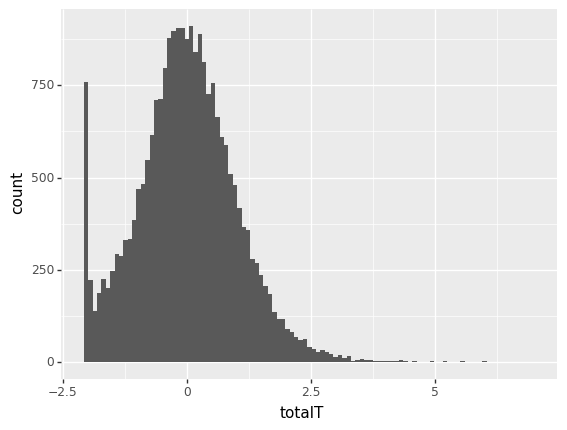

<ggplot: (170913148700)>

In [ ]:
from plotnine import *
(
    ggplot(
        all_pandas[all_pandas.session_id != 21020618143279870],
        aes(x = "totalT", y = after_stat('count'))
    ) + geom_histogram() + labs(y="count") 
)

In [ ]:
if False:
    train_to_parquet.write.mode("overwrite").parquet(r".\data\df_train")
    test_to_parquet.write.mode("overwrite").parquet(r".\data\df_test")
    trans_all.write.mode("overwrite").parquet(r".\data\trans_all")